In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from prometheus_api_client import PrometheusConnect
from math import sqrt
import datetime

In [15]:
PROMETHEUS_URL = 'http://localhost:9090'
PROMETHEUS_ACCESS_TOKEN = ''  

# Initialize Prometheus connection
prom = PrometheusConnect(url=PROMETHEUS_URL, disable_ssl=True)

# Queries
ram_query = '100 - ((avg_over_time(node_memory_MemAvailable_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]) * 100) / avg_over_time(node_memory_MemTotal_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]))'
cpu_query = '(sum by(instance) (irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints", mode!="idle"}[5m15s])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s])))) * 100'

In [16]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [22]:
def predict(
    prom,
    query,
    name="value",
    start_days_ago=7,
    step="3000",
    look_back=3,
    epochs=1000,
    batch_size=1,
    patience=10,
    degree=0.0005,
):
    end_time = datetime.datetime.now()
    start_time = end_time - datetime.timedelta(days=start_days_ago)

    data = prom.custom_query_range(
        query=query, start_time=start_time, end_time=end_time, step=step
    )

    if data:
        timestamps = [
            datetime.datetime.fromtimestamp(float(item[0]))
            for item in data[0]["values"]
        ]
        value = [float(item[1]) for item in data[0]["values"]]

        df = pd.DataFrame(data={"timestamp": timestamps, name: value})
        df["timestamp"] = pd.to_datetime(df["timestamp"])

        # Normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df[name].values.reshape(-1, 1))


        train_size = int(len(scaled_data) * 0.67)
        test_size = len(scaled_data) - train_size
        train, test = (
            scaled_data[0:train_size, :],
            scaled_data[train_size : len(scaled_data), :],
        )

        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(1, look_back), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(25, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss="mean_squared_error", optimizer=Adam(degree))

        # Fit the model with early stopping
        early_stop = EarlyStopping(monitor="val_loss", patience=patience, verbose=1)
        history = model.fit(
            trainX,
            trainY,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(testX, testY),
            callbacks=[early_stop],
        )

        # Predictions for training and testing dataset
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # Invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])

        # Calculate RMSE
        trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
        testScore = sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
        print("Train Score: %.2f RMSE" % (trainScore))
        print("Test Score: %.2f RMSE" % (testScore))

        # Visualization
        plt.figure(figsize=(15, 6))
        plt.plot(df["timestamp"], df[name], label="Original Data")
        plt.plot(
            df["timestamp"],
            np.pad(
                trainPredict.ravel(),
                (look_back, len(df) - len(trainPredict) - look_back),
                "constant",
                constant_values=np.nan,
            ),
            label="Train Prediction",
        )
        plt.plot(
            df["timestamp"],
            np.pad(
                testPredict.ravel(),
                (
                    len(trainPredict) + 2 * look_back + 1,
                    len(df) - len(testPredict) - len(trainPredict) - 2 * look_back - 1,
                ),
                "constant",
                constant_values=np.nan,
            ),
            label="Test Prediction",
        )
        plt.title(f"{name} Prediction")
        plt.xlabel("Timestamp")
        plt.ylabel(name)
        plt.legend()
        plt.show()
    else:
        print("No data returned from Prometheus or unexpected data format.")


/Users/william/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 52: early stopping
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 0.72 RMSE
Test Score: 3.46 RMSE


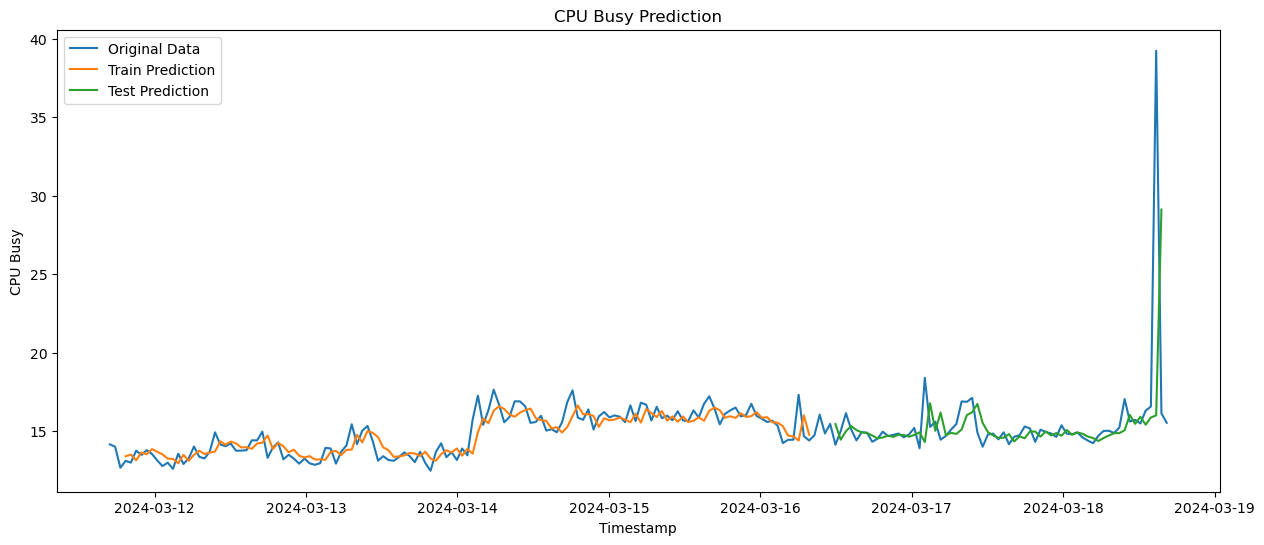

In [23]:
predict(prom, cpu_query, name="CPU Busy", patience=50)

/Users/william/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 291: early stopping
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 0.45 RMSE
Test Score: 1.23 RMSE


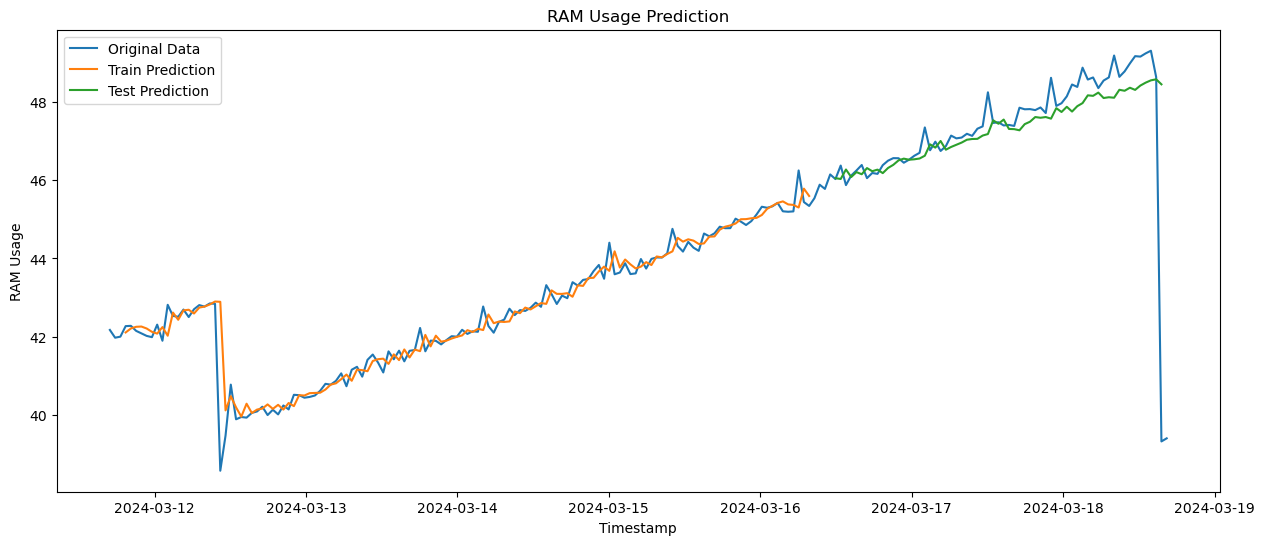

In [24]:
predict(prom, ram_query, name="RAM Usage", patience=50)